In [5]:
import os
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
import random

# Data Preprocessing

In [6]:
stop_words = stopwords.words('english')

In [7]:
negative_documents = []
max_len_negative = 0
for file in os.listdir('train_data/neg'):
    with open('train_data/neg/' + file) as f:
        text = f.read()
        tokens = word_tokenize(text)
        translator = str.maketrans('', '', punctuation)
        tokens = [w.translate(translator) for w in tokens]
        tokens = [w for w in tokens if not w in stop_words]
        if len(tokens) > max_len_negative:
            max_len_negative = len(tokens)
        negative_documents.append(' '.join(tokens))
len(negative_documents)

1000

In [8]:
positive_documents = []
max_len_positive = 0
for file in os.listdir('train_data/pos'):
    with open('train_data/pos/' + file) as f:
        text = f.read()
        tokens = word_tokenize(text)
        translator = str.maketrans('', '', punctuation)
        tokens = [w.translate(translator) for w in tokens]
        tokens = [w for w in tokens if not w in stop_words]
        if len(tokens) > max_len_positive:
            max_len_positive = len(tokens)
        positive_documents.append(' '.join(tokens))
len(positive_documents)

1000

In [9]:
max_len = max(max_len_negative, max_len_positive)

In [10]:
random.shuffle(negative_documents)
random.shuffle(positive_documents)

In [11]:
X_train = negative_documents[:800] + positive_documents[:800]
y_train = [0 for _ in range(800)] + [1 for _ in range(800)]
X_test = negative_documents[800:] + positive_documents[800:]
y_test = [0 for _ in range(200)] + [1 for _ in range(200)]

# Multichannel CNN

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.layers import concatenate
import numpy as np

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [14]:
vocab_len = len(tokenizer.word_index) + 1

In [15]:
encoded = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(encoded, maxlen=max_len, padding='post')
encoded_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(encoded_test, maxlen=max_len, padding='post')

In [16]:
input1 = Input(shape=(max_len,))
embedding1 = Embedding(vocab_len, 100)(input1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPool1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)

input2 = Input(shape=(max_len,))
embedding2 = Embedding(vocab_len, 100)(input2)
conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPool1D(pool_size=2)(drop2)
flat2= Flatten()(pool2)

input3 = Input(shape=(max_len,))
embedding3 = Embedding(vocab_len, 100)(input3)
conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPool1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)

input4 = Input(shape=(max_len,))
embedding4 = Embedding(vocab_len, 100)(input4)
conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(embedding4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPool1D(pool_size=2)(drop4)
flat4 = Flatten()(pool4)

conc = concatenate([flat1, flat2, flat3, flat4])
dense1 = Dense(100, activation='relu')(conc)
dense2 = Dense(10, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

In [17]:
model = Model(inputs=[input1, input2, input3, input4], outputs=output)

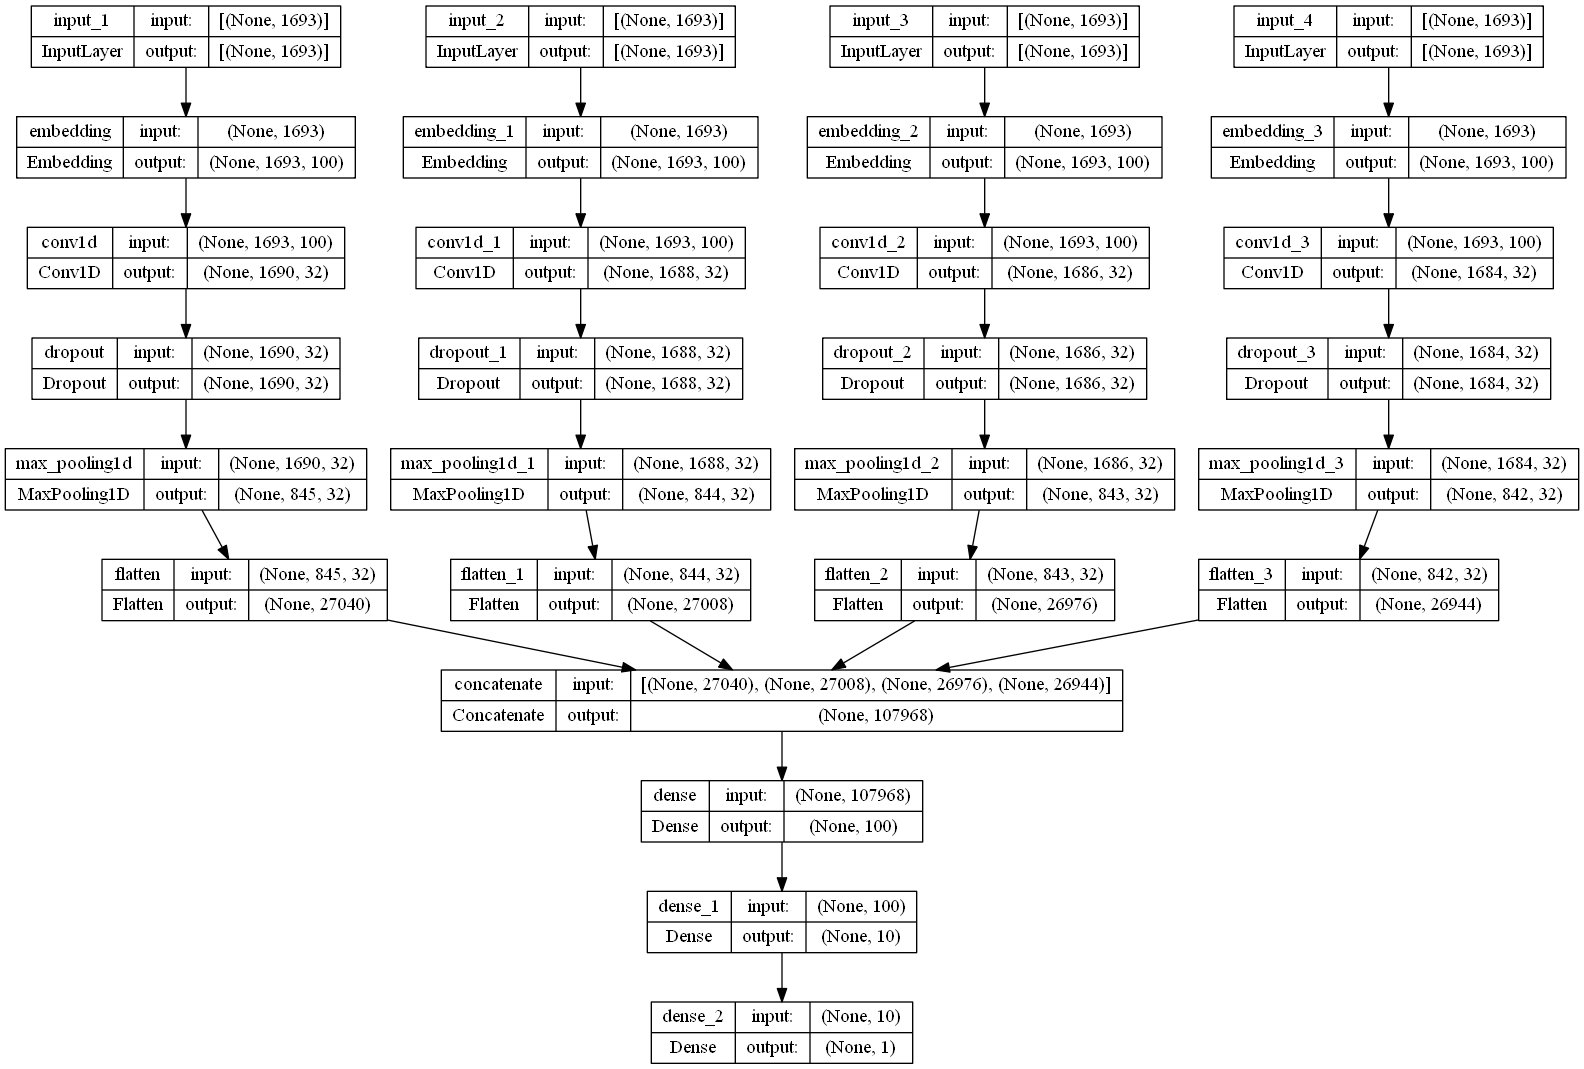

In [18]:
plot_model(model, show_shapes=True)

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model.fit([padded, padded, padded, padded], np.array(y_train), epochs=10, batch_size=200, validation_data=([padded_test, padded_test, padded_test, padded_test], np.array(y_test)))

Epoch 1/10
8/8 [==============================] - 25s 3s/step - loss: 0.9797 - accuracy: 0.4981 - val_loss: 0.7208 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 23s 3s/step - loss: 0.6879 - accuracy: 0.5312 - val_loss: 0.6950 - val_accuracy: 0.5375
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 0.6448 - accuracy: 0.6488 - val_loss: 0.6989 - val_accuracy: 0.5250
Epoch 4/10
8/8 [==============================] - 24s 3s/step - loss: 0.5456 - accuracy: 0.8544 - val_loss: 0.6854 - val_accuracy: 0.5700
Epoch 5/10
8/8 [==============================] - 24s 3s/step - loss: 0.3484 - accuracy: 0.9281 - val_loss: 0.6071 - val_accuracy: 0.6775
Epoch 6/10
8/8 [==============================] - 24s 3s/step - loss: 0.1193 - accuracy: 0.9981 - val_loss: 0.4540 - val_accuracy: 0.8375
Epoch 7/10
8/8 [==============================] - 24s 3s/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.3829 - val_accuracy: 0.8450
Epoch 8/10
8/8 [==================

In [62]:
pred_cnn = model.predict([padded_test, padded_test, padded_test, padded_test])

13/13 [==============================] - 1s 75ms/step


In [63]:
for n in range(400):
    if pred_cnn[n] < 0.5:
        pred_cnn[n] = 0
    else:
        pred_cnn[n] = 1

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
print('CNN:',classification_report(y_test, pred_cnn))

CNN:               precision    recall  f1-score   support

           0       0.81      0.92      0.86       200
           1       0.91      0.79      0.84       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400

